<a href="https://colab.research.google.com/github/girija2204/DLTopics/blob/master/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D, Lambda
import tensorflow.keras.backend as k
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
def get_data(dataset, count=None, same_label=False, label=None, categories=None):
  images = dataset.images
  targets = dataset.target
  if count is None:
    return images, targets

In [ ]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images_dataset):
        pos_indices = label_wise_indices.get(labels_dataset[index])
        pos_image = images_dataset[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels_dataset != labels_dataset[index])
        neg_image = images_dataset[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

In [ ]:
def generate_test_image_pairs(images_dataset, labels_dataset, image):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                        label == curr_label])
  
    pair_images = []
    pair_labels = []
    for label, indices_for_label in label_wise_indices.items():
        test_image = images_dataset[np.random.choice(indices_for_label)]
        pair_images.append((image, test_image))
        pair_labels.append(label)
    return np.array(pair_images), np.array(pair_labels)

In [ ]:
def create_model():
    inputs = Input((64, 64, 1))
    x = Conv2D(96, (11, 11), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(384, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    pooledOutput = Dense(1024)(pooledOutput)
    outputs = Dense(128)(pooledOutput)

    model = Model(inputs, outputs)
    return model

In [ ]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

In [ ]:
feature_extractor = create_model()
imgA = Input(shape=(64, 64, 1))
imgB = Input(shape=(64, 64, 1))
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

distance = Lambda(euclidean_distance)([featA, featB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [ ]:
ol_faces = datasets.fetch_olivetti_faces()
ol_images, ol_targets = get_data(dataset=ol_faces)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
images_dataset = ol_images
labels_dataset = ol_targets

In [ ]:
images_pair, labels_pair = generate_train_image_pairs(images_dataset, labels_dataset)

In [ ]:
fig = plt.figure(figsize=(1,2))
fig.add_subplot(1,2,1)
plt.imshow(images_pair[1,0], cmap="gray")
fig.add_subplot(1,2,2)
plt.imshow(images_pair[1,1], cmap="gray")
plt.show()

In [ ]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit([images_pair[:, 0], images_pair[:, 1]], labels_pair[:],validation_split=0.25,batch_size=32,epochs=100)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/models/assets


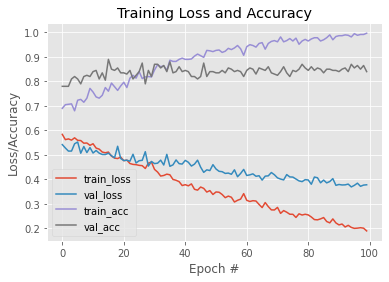

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/models")
plot_training(history, "/content/drive/MyDrive/Colab Notebooks/plots/plot.png")

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/imgs/image1_20210118100647.png")
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_img = gray_img / 255
gray_img.shape

(64, 64)

In [ ]:
images_dataset[0].shape

(64, 64)

In [ ]:
pair_image1 = np.expand_dims(gray_img, axis=-1)
pair_image1 = np.expand_dims(pair_image1, axis=0)

In [ ]:
pair_image2 = np.expand_dims(images_dataset[10], axis=-1)
pair_image2 = np.expand_dims(pair_image2, axis=0)

In [ ]:
predictions = model.predict([pair_image1, pair_image2])
predictions[0][0]

0.23747268

In [ ]:
predictions

array([[0.23747268]], dtype=float32)

In [ ]:
test_image_pairs, test_label_pairs = generate_test_image_pairs(images_dataset, labels_dataset, gray_img)

In [ ]:
def plot_face_predictions(pair, prediction, index):
    rounded_pred = round(prediction, 1)
    concatenated_img = np.concatenate((pair[0], pair[1]), axis=1)
    concatenated_img = cv2.resize(concatenated_img, (448, 224), interpolation=cv2.INTER_CUBIC)
    concatenated_img = np.float32(concatenated_img)
    concatenated_img = cv2.cvtColor(concatenated_img, cv2.COLOR_GRAY2RGB)
    cv2.putText(concatenated_img, f"Similarity: {str(rounded_pred)}",
                (60 + math.ceil(concatenated_img.shape[0] / 2), 0 + math.ceil(concatenated_img.shape[1] / 2)),
                cv2.FONT_HERSHEY_COMPLEX, 1 / 2, (255, 0, 0), 1)
    cv2.imshow("image1", concatenated_img)
    if prediction >= 0.5:
        cv2.waitKey(1000)
    else:
        cv2.waitKey(500)

In [ ]:
probs = []
for index, pair in enumerate(test_image_pairs):
    pair_image1 = np.expand_dims(pair[0], axis=-1)
    pair_image1 = np.expand_dims(pair_image1, axis=0)
    pair_image2 = np.expand_dims(pair[1], axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]
    probs.append(prediction)
    print(prediction)
    plot_face_predictions(pair, prediction, index)
print(probs)
